In [ ]:
import matplotlib.lines as mlines  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import arviz as az
import pymc as pm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

In [2]:
plt.rcParams.update({'font.size': 15})
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Computational analysis of articles published in the special issue of *Computational Culture* on *Bayesian Knowledge: Situated and Pluriversal Perspectives*

# Load data

We load text of the 9 articles in our special issue.

In [ ]:
# article names are initials of authors
article_names = ["A","BBN","C","dF","G","L", "M", "M-C", "U"]
n_articles = len(article_names)
article_ids = np.arange(n_articles)

In [ ]:
# load articles
articles = []
for name in article_names:
    with open("data/revision-with-abstracts/"+name+".txt") as text:
        articles.append(text.read())

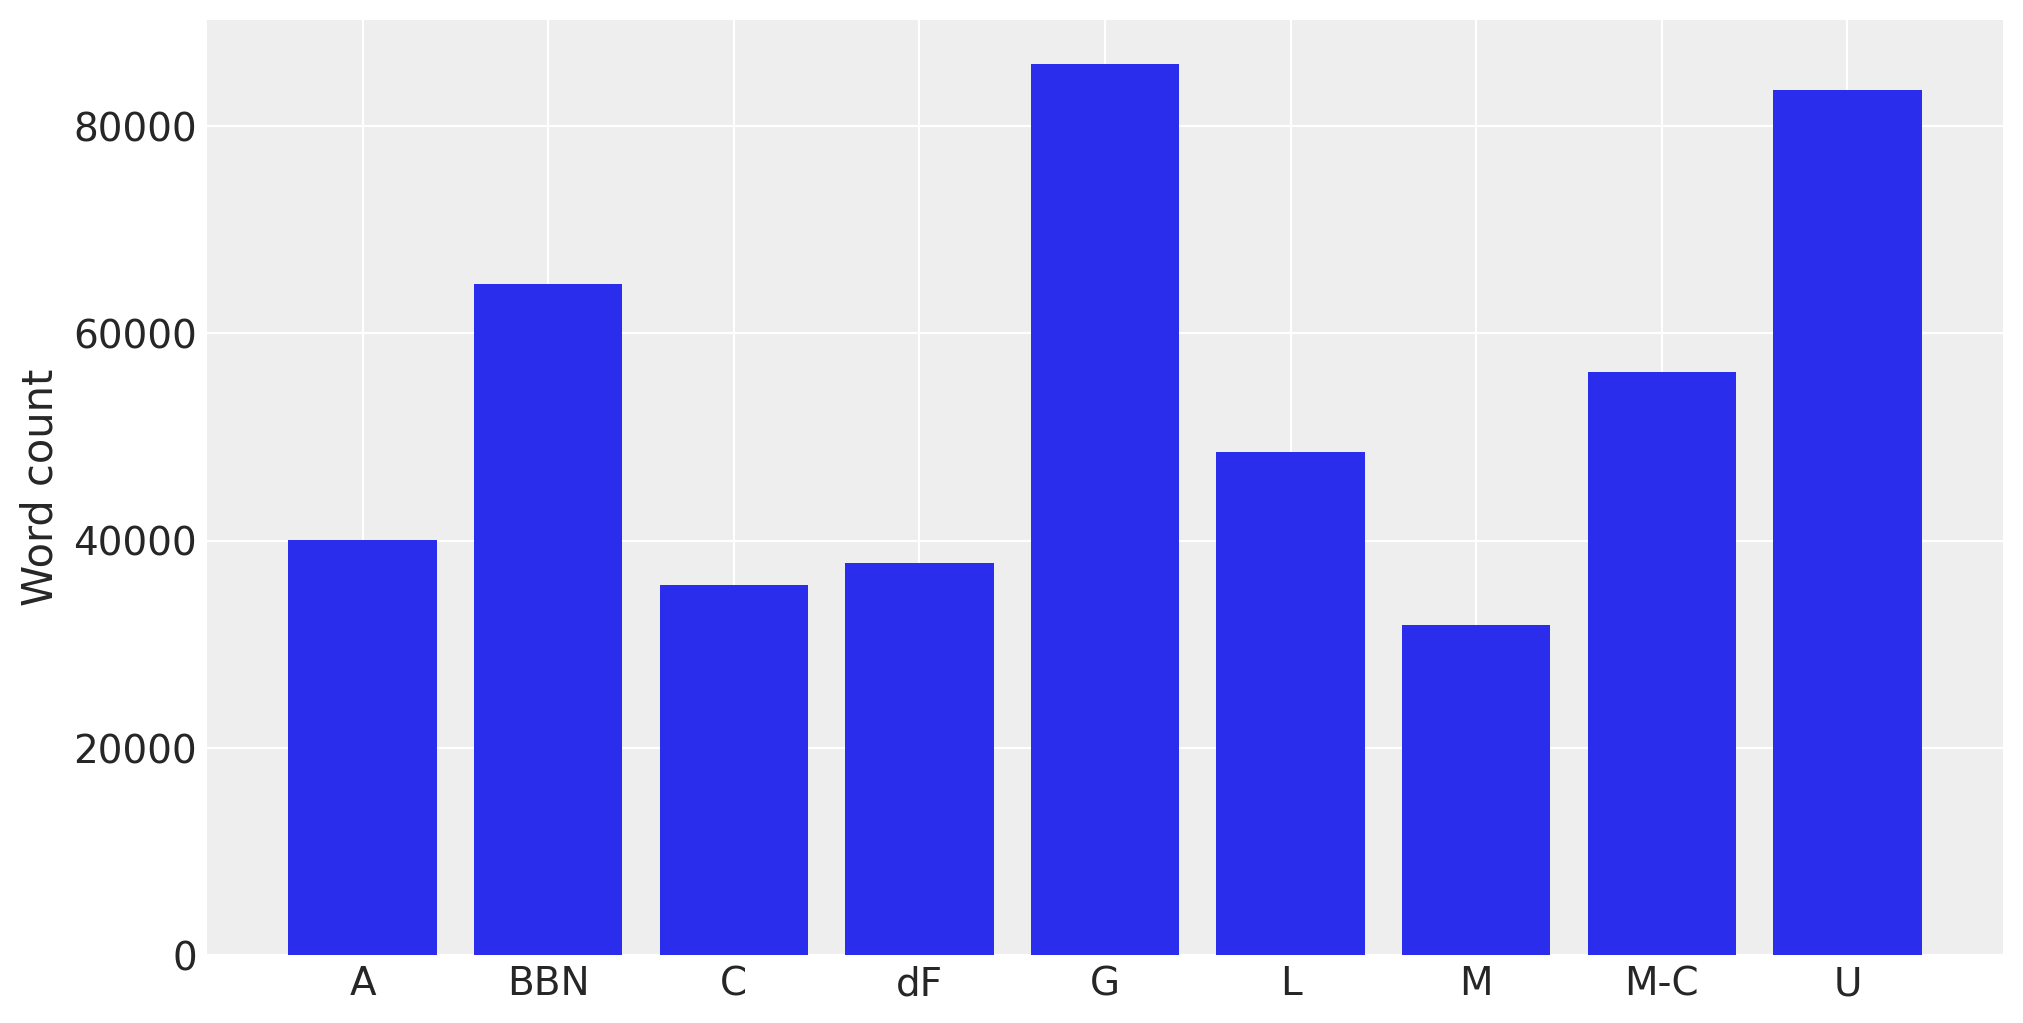

In [6]:
# compute article length
article_length = [len(article) for article in articles]

# create bar plot
fig, ax = plt.subplots(1,figsize=(10, 5))
ax.bar(article_names,article_length)
ax.set(ylabel="Word count")
plt.show()

# Analysis of term count (TC) and document frequency (DF)

We compute the term count and document frequency of the words appearing in the special issue.

In [8]:
# compute document-term matrix
vectorizer = CountVectorizer(stop_words="english",ngram_range=(1, 1))
word_counts = vectorizer.fit_transform(articles)
words = vectorizer.get_feature_names_out()
dt_matrix =  pd.DataFrame(word_counts.toarray(), columns=words)

In [9]:
# compute TC and DF
TC = dt_matrix.sum(axis=0)
DF = (dt_matrix > 0).sum(axis=0)

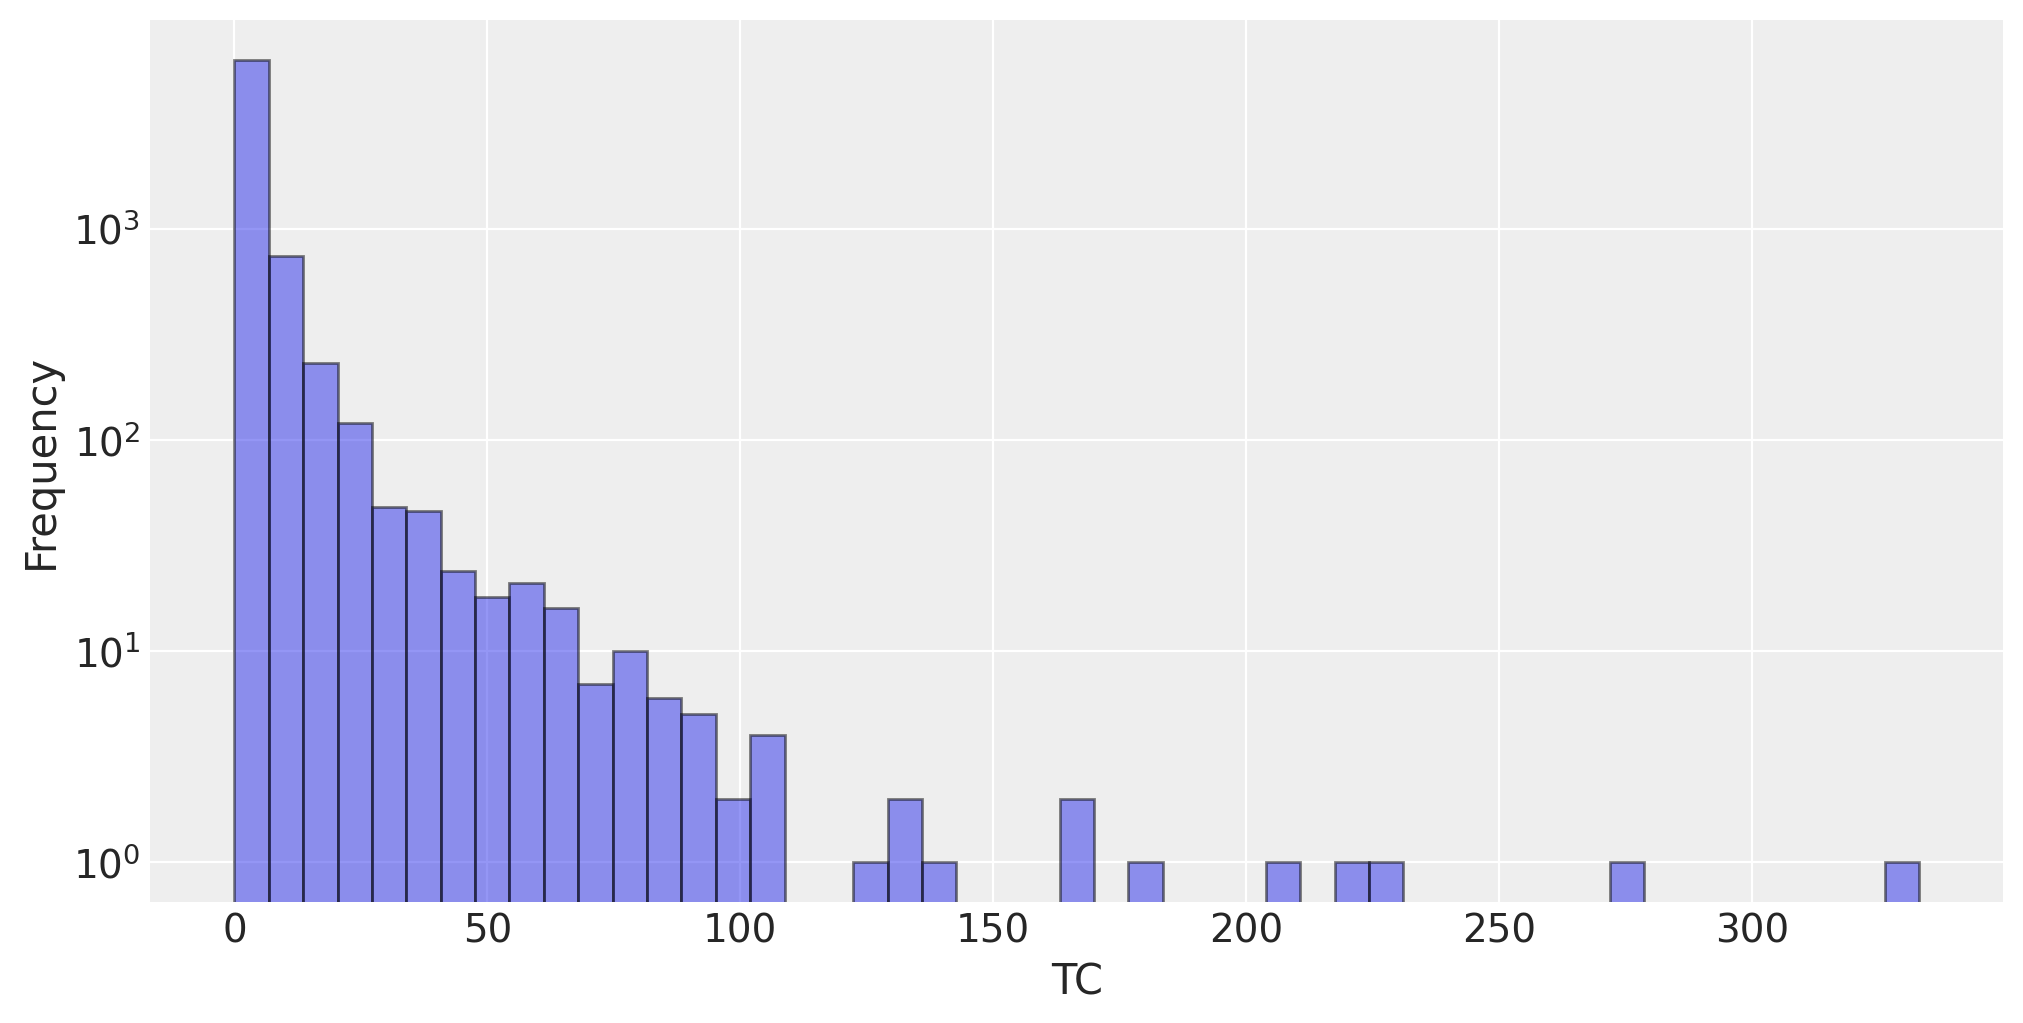

In [10]:
# visualise TC distributions
fig, ax = plt.subplots(1,figsize=(10, 5))
bins = np.linspace(0,TC.max()+2,50)
ax.hist(TC, bins=bins,alpha=0.5, edgecolor='black')
ax.set(xlabel="TC",ylabel="Frequency",yscale="log")
plt.show()

In [ ]:
# only consider words that appear at least 132 times in corpus; this leads to 10 words
words_considered_ind = TC > 131
words_considered_str = (words_considered_ind[words_considered_ind == True].index)
TC = TC[words_considered_ind]
DF = DF[words_considered_ind]

In [ ]:
# term counts of top 10 words
TC

bayesian       276
data           207
knowledge      220
learning       166
machine        132
model          228
opacity        164
people         139
probability    331
world          178
dtype: int64

In [ ]:
# document frequency of top 10 words
DF

bayesian       9
data           9
knowledge      9
learning       7
machine        7
model          9
opacity        2
people         6
probability    8
world          9
dtype: int64

We create a scatter plot of the term counts and document frequencies of the top 10 words in the special issue.

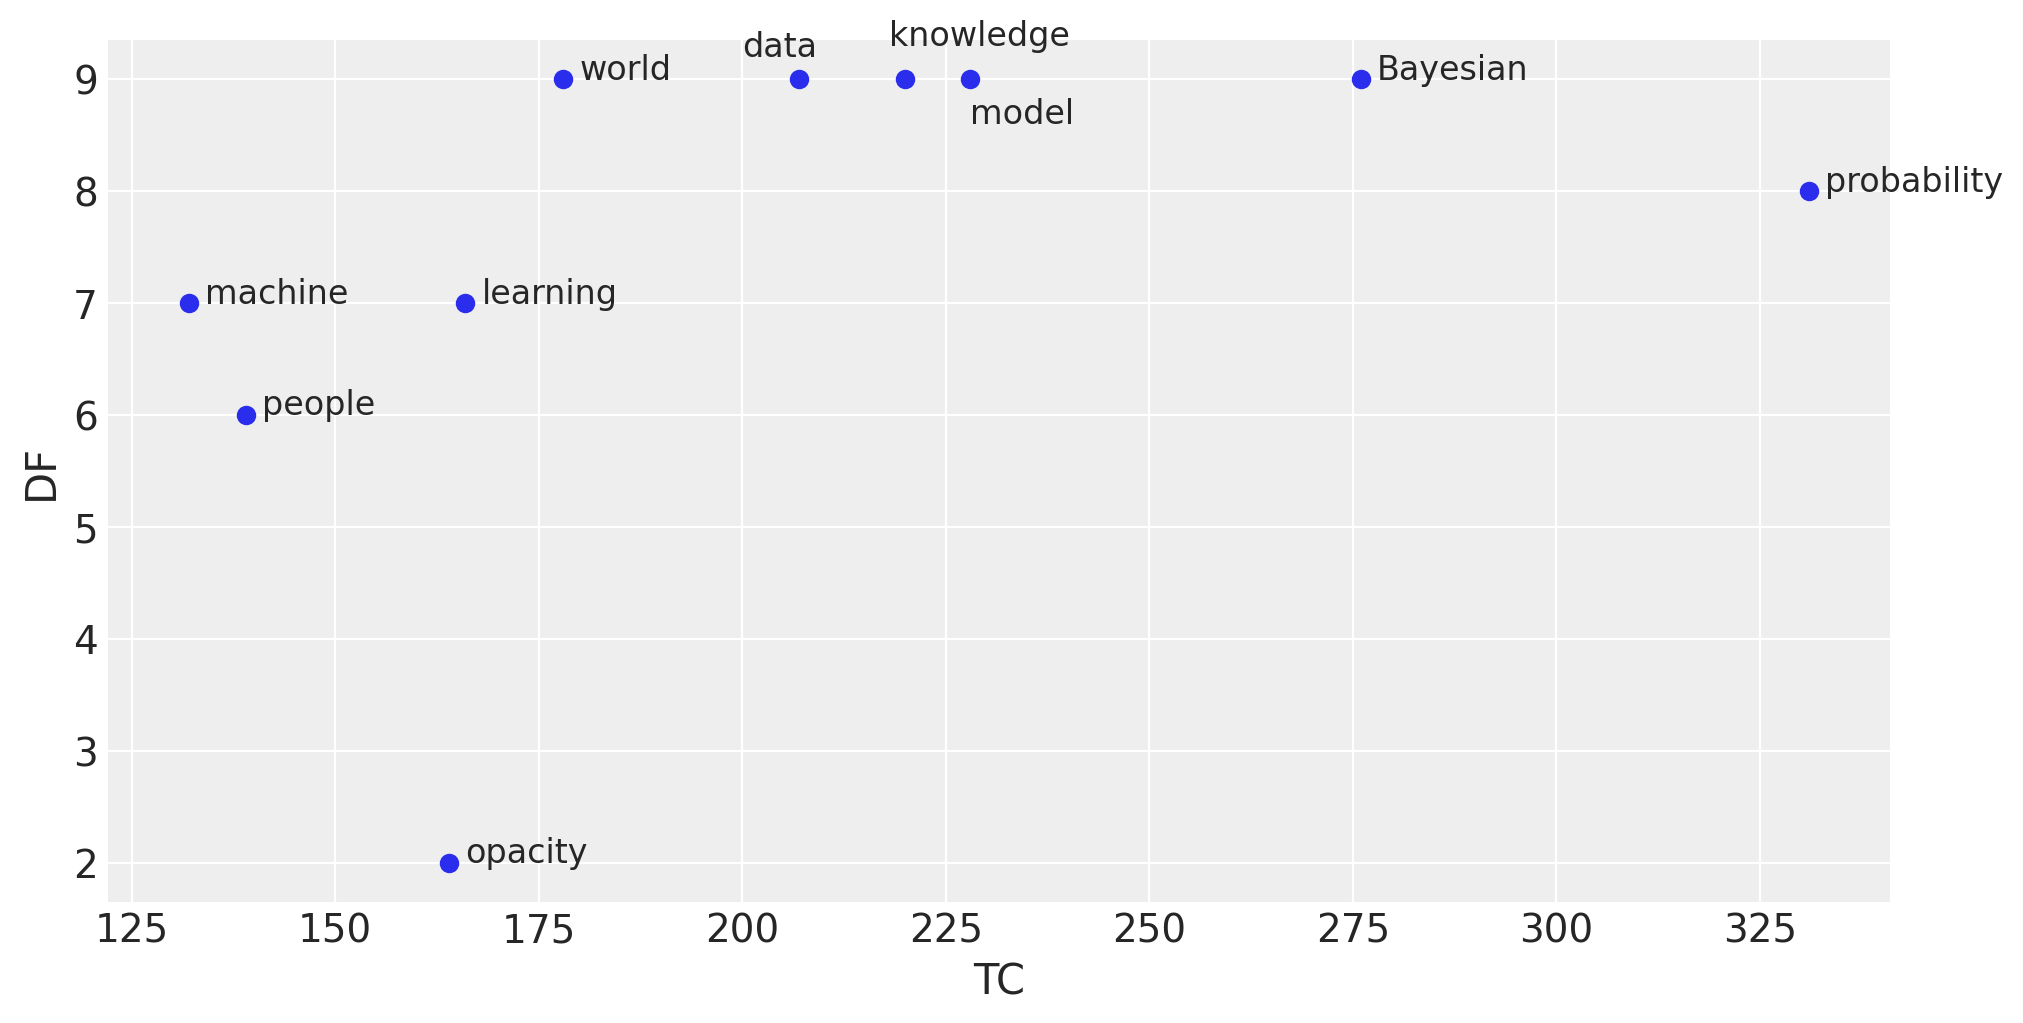

In [ ]:
# create scatter plot
fig, ax = plt.subplots(1,figsize=(10, 5))
ax.scatter(TC[words_considered_ind],DF[words_considered_ind])
# annotate words
for word in words_considered_str:
    if word == "bayesian":
        ax.annotate("Bayesian", xy=(TC[word]+2,DF[word]), fontsize=12,zorder=3)
    elif word == "data":
        ax.annotate(word, xy=(TC[word]-7,DF[word]+0.2), fontsize=12,zorder=3)
    elif word == "knowledge":
        ax.annotate(word, xy=(TC[word]-2,DF[word]+0.3), fontsize=12,zorder=3)
    elif word == "model":
        ax.annotate(word, xy=(TC[word],DF[word]-0.4), fontsize=12,zorder=3)
    else:
        ax.annotate(word, xy=(TC[word]+2,DF[word]), fontsize=12,zorder=3)
ax.set(xlabel="TC",ylabel="DF")
plt.show()

# Standard linear regression

We apply standard linear regression with DF as our dependent variable and TC as our independent variable.

In [15]:
# X is term count and y is document frequency
X = np.array(TC).reshape(-1, 1)
y = np.array(DF)

In [16]:
# fit linear regression model
reg = LinearRegression().fit(X,y)
print("R2 score:",round(reg.score(X,y),3))
print("Slope:",round(reg.coef_[0],3))
print("intercept:", round(reg.intercept_,3))

R2 score: 0.207
Slope: 0.016
intercept: 4.206


In [17]:
# get predicted linear regression line
xticks = np.arange(100,360).reshape(-1,1)
y_pred = reg.predict(xticks)

We can plot the regression line on top of our scatter plot of top 10 words.

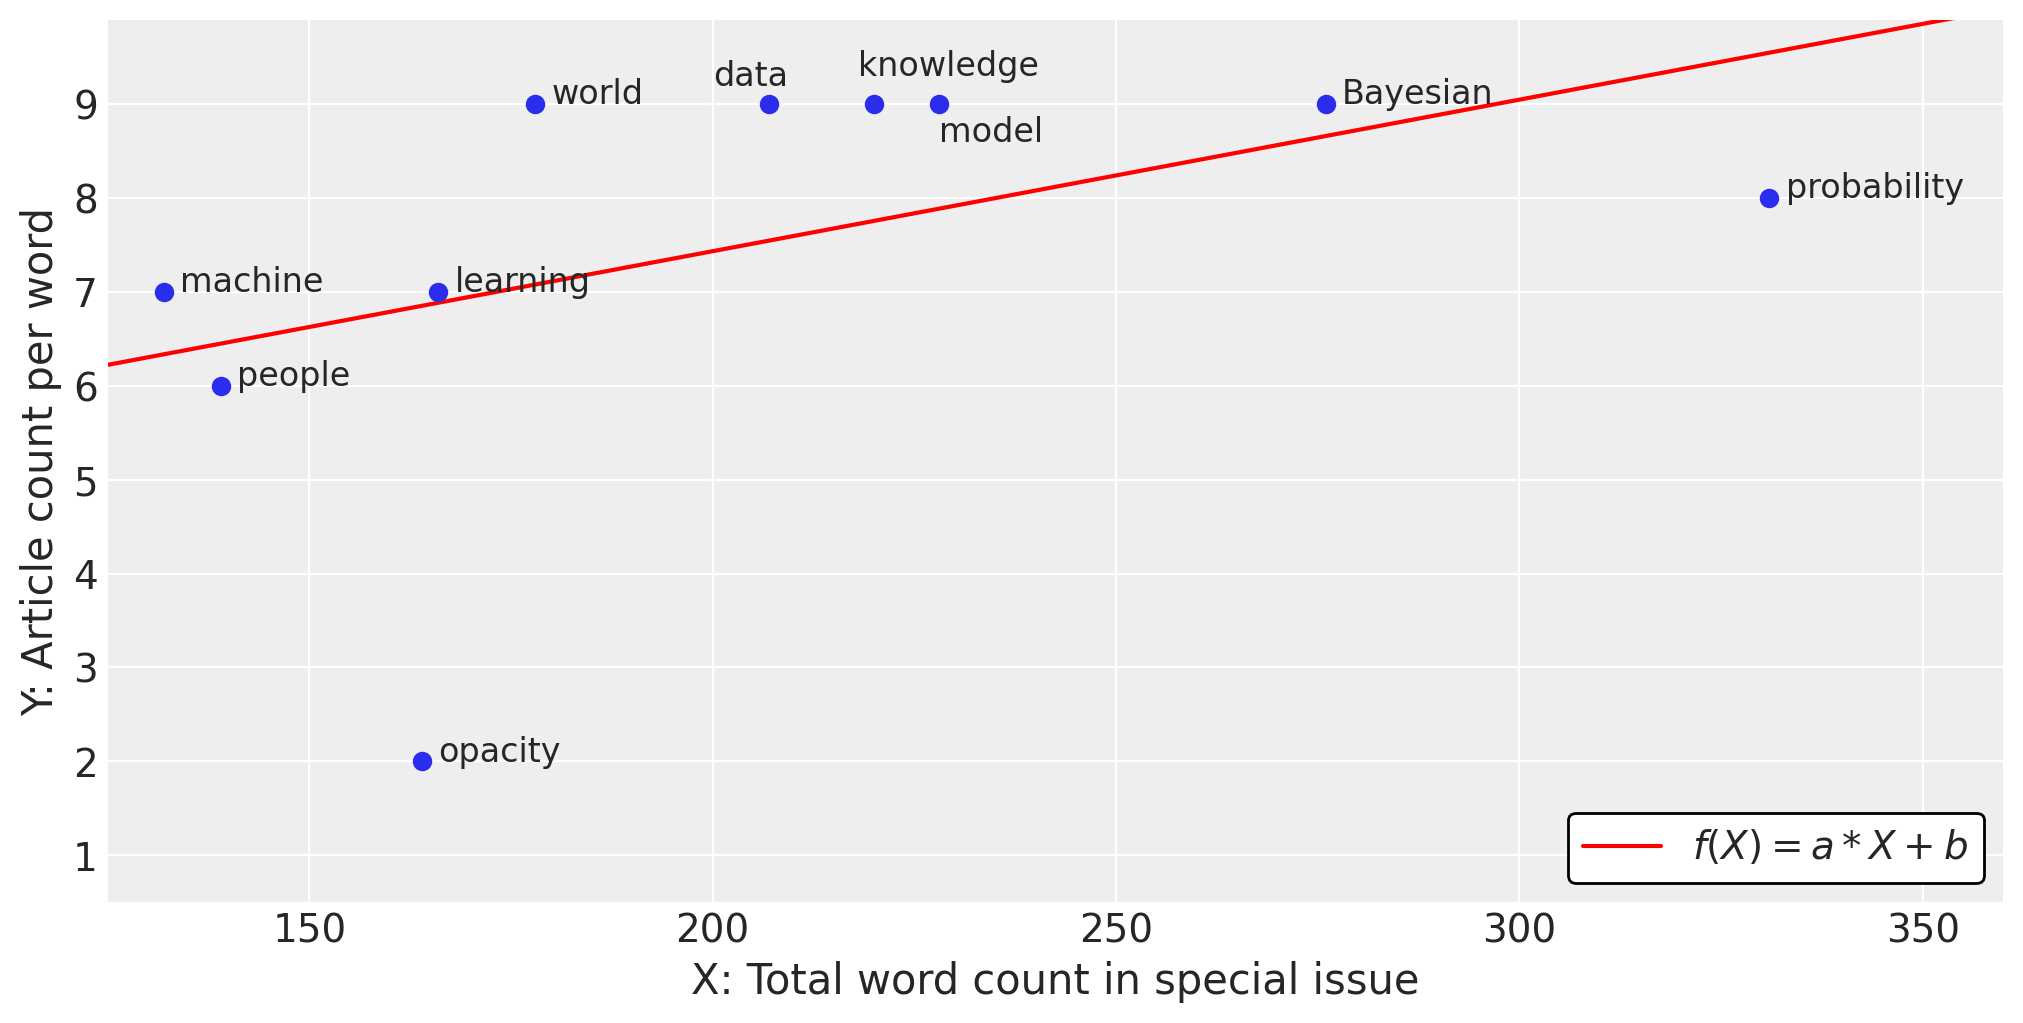

In [19]:
fig, ax = plt.subplots(1,figsize=(10, 5))
# plot word statistics
ax.scatter(TC[words_considered_ind],DF[words_considered_ind],alpha=1,zorder=2)
# plot linear regression line
ax.plot(xticks,y_pred,c="red",label="OLS",zorder=1)
# annotate words
for word in words_considered_str:
    if word == "bayesian":
        ax.annotate("Bayesian", xy=(TC[word]+2,DF[word]), fontsize=12,zorder=3)
    elif word == "data":
        ax.annotate(word, xy=(TC[word]-7,DF[word]+0.2), fontsize=12,zorder=3)
    elif word == "knowledge":
        ax.annotate(word, xy=(TC[word]-2,DF[word]+0.3), fontsize=12,zorder=3)
    elif word == "model":
        ax.annotate(word, xy=(TC[word],DF[word]-0.4), fontsize=12,zorder=3)
    else:
        ax.annotate(word, xy=(TC[word]+2,DF[word]), fontsize=12,zorder=3)
# label axes
ax.set(xlabel="X: Total word count in special issue",ylabel="Y: Article count per word", ylim=(0.5,9.9),xlim=(125,360),yticks=np.arange(1,10))

# Create a legend with a red line  
red_line = mlines.Line2D([], [], color='red', label=r'$f(X) = a * X + b$')  
plt.legend(handles=[red_line],loc=4,   
           facecolor='white',  # White background  
           edgecolor='black',  # Black border  
           frameon=True,
           framealpha=1.0) 
plt.savefig("figures/standard_lr.pdf", bbox_inches='tight')
plt.show()

# Bayesian linear regression with PyMC

We apply Bayesian linear regression to the same task as before, using PyMC.

In [20]:
# X is term count and y is document frequency
X = np.array(TC)
y = np.array(DF)

As prior distributions we choose standard normal for the slope and variance, and half-normal for the intercept. We then infer the posterior distribution using NUTS sampling.

In [22]:
# define Bayesian linear regression model
with pm.Model() as model:
    # Define priors
    sigma = pm.Normal("sigma", 0, sigma=1)
    intercept = pm.HalfNormal("Intercept $b$", sigma=1)
    slope = pm.Normal("Slope $a$", sigma=1)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * X, sigma=sigma, observed=y)

    # Inference!
    # draw 4000 posterior samples using NUTS sampling
    idata = pm.sample(4000,random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept $b$, Slope $a$]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 14 seconds.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# we can inspect the inference data
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

We use arviz to produce different plots for the (joint) posterior distribution of slope and intercept.

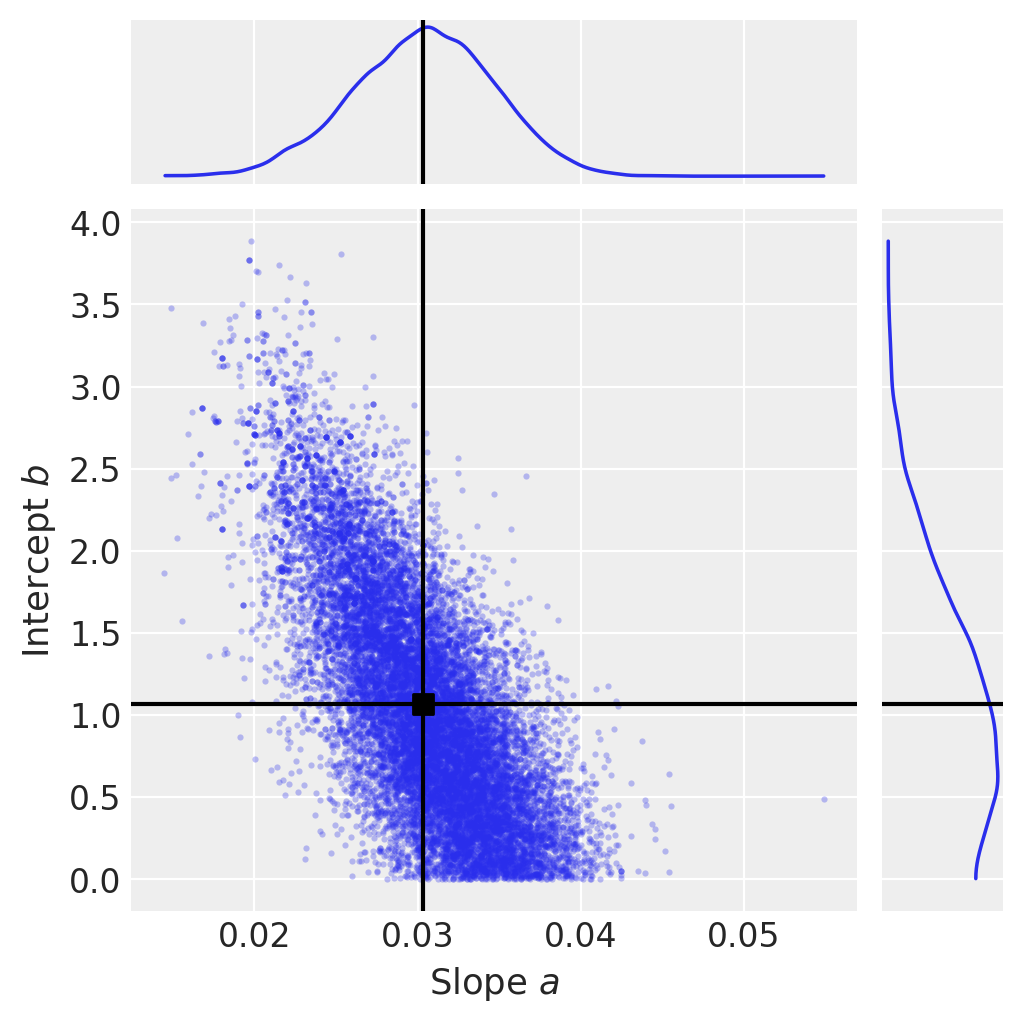

In [ ]:
ax = az.plot_pair(idata, figsize=(5, 5), var_names="~sigma",kind='scatter',marginals=True,scatter_kwargs={"s":20,"alpha":0.3},point_estimate="mean")
plt.savefig("figures/bayes_ab_posterior.svg", bbox_inches='tight')

In [ ]:
# get statistics of the posterior distribution
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.993,0.365,1.356,2.677,0.005,0.004,5109.941,6362.340,1.001
Slope $a$,0.030,0.004,0.022,0.038,0.000,0.000,4126.400,4467.497,1.002
Intercept $b$,1.065,0.688,0.000,2.262,0.011,0.008,3495.243,3856.010,1.002


Finally, we can sample regression lines from the joint posterior distribution of slope and intercept.

In [29]:
# extract posterior samples  
intercepts = idata.posterior['Intercept $b$'].values.flatten()  
slopes = idata.posterior['Slope $a$'].values.flatten()  

# we shuffle the samples
rng = np.random.default_rng(3)
perm = rng.permutation(len(intercepts))
intercepts = intercepts[perm]
slopes = slopes[perm]

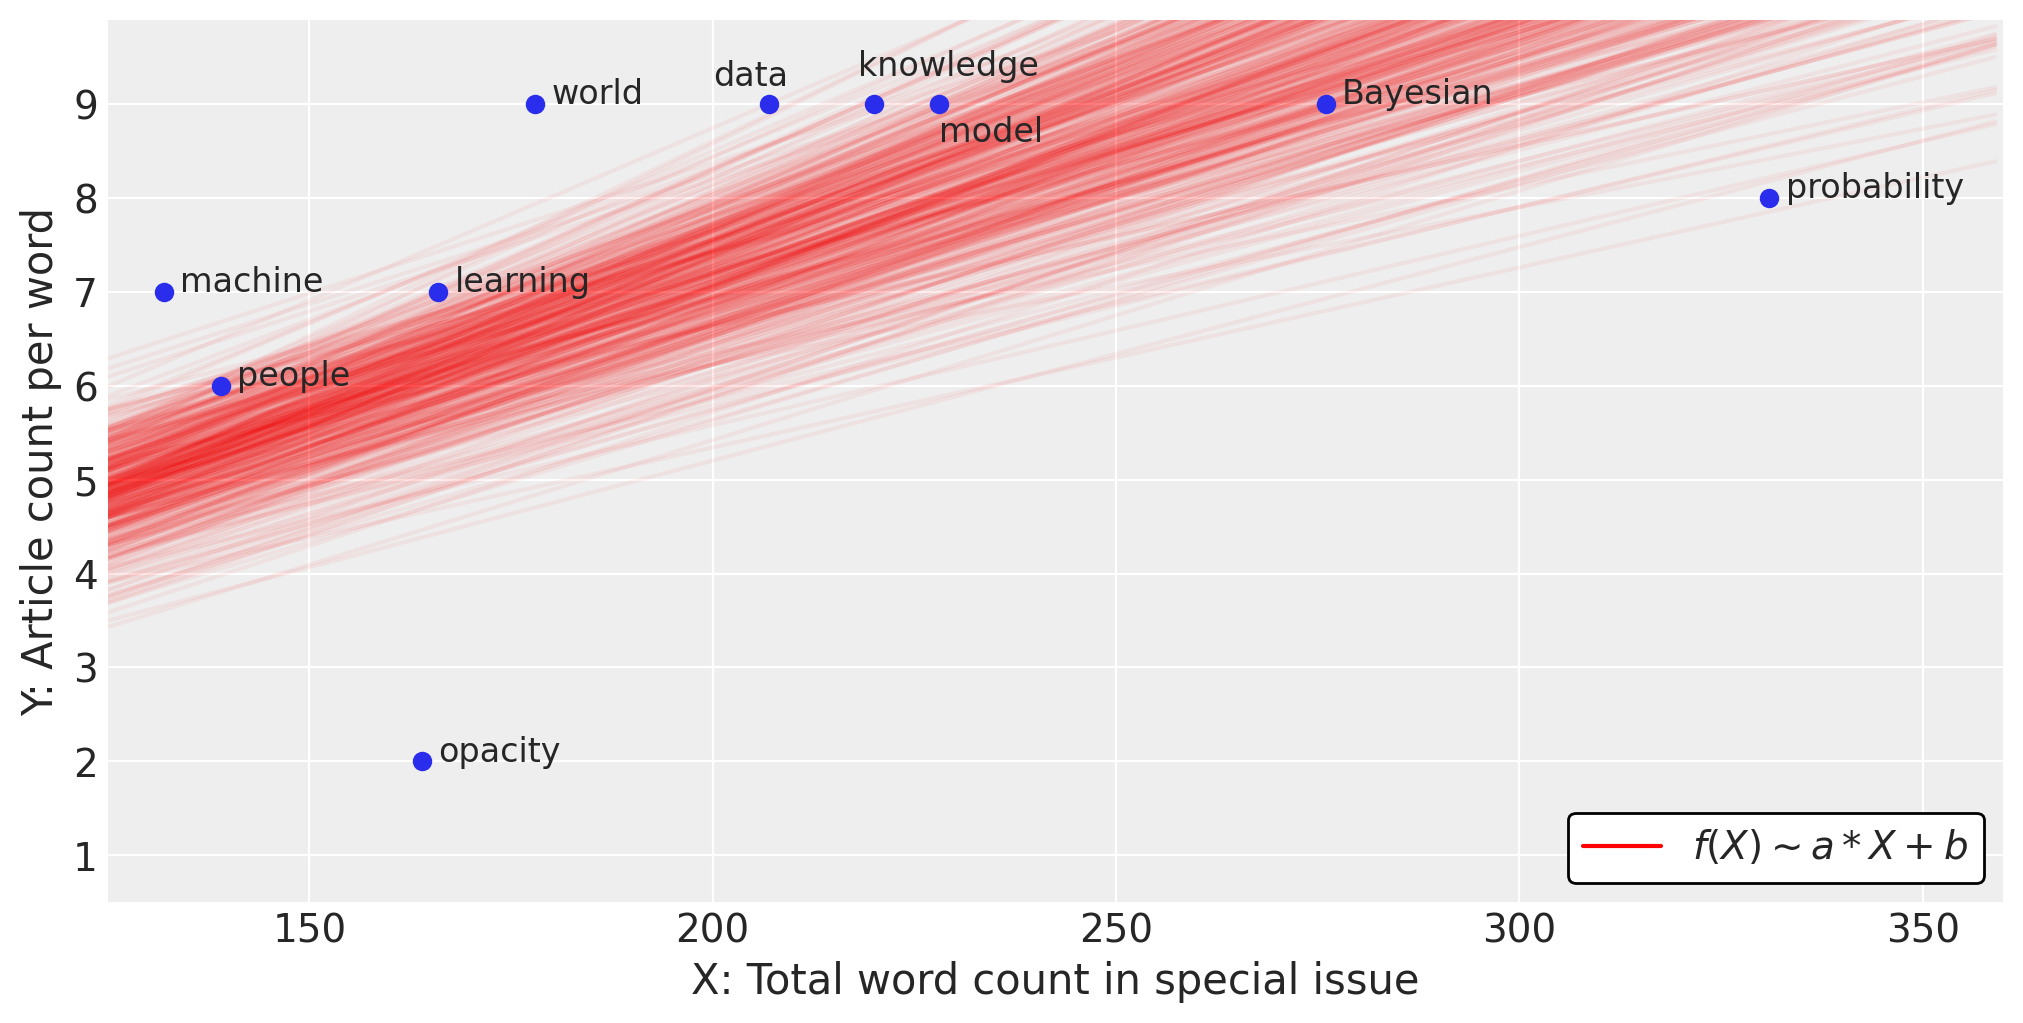

In [ ]:
fig, ax = plt.subplots(1,figsize=(10, 5))
# plot word statistics
ax.scatter(TC[words_considered_ind],DF[words_considered_ind],alpha=1,zorder=2)
# draw multiple linear regression lines from posterior samples
xticks = np.arange(100,360)
for i in range(min(500, len(intercepts))):  
    y_line = intercepts[i] + slopes[i] * xticks  
    plt.plot(xticks, y_line, color="red", alpha=0.05, zorder=1)  
# annotate words
for word in words_considered_str:
    if word == "bayesian":
        ax.annotate("Bayesian", xy=(TC[word]+2,DF[word]), fontsize=12,zorder=3)
    elif word == "data":
        ax.annotate(word, xy=(TC[word]-7,DF[word]+0.2), fontsize=12,zorder=3)
    elif word == "knowledge":
        ax.annotate(word, xy=(TC[word]-2,DF[word]+0.3), fontsize=12,zorder=3)
    elif word == "model":
        ax.annotate(word, xy=(TC[word],DF[word]-0.4), fontsize=12,zorder=3)
    else:
        ax.annotate(word, xy=(TC[word]+2,DF[word]), fontsize=12,zorder=3)
# label axes
ax.set(xlabel="X: Total word count in special issue",ylabel="Y: Article count per word", ylim=(0.5,9.9),xlim=(125,360),yticks=np.arange(1,10))

# Create a legend with a red line  
red_line = mlines.Line2D([], [], color='red', label=r'$f(X) \sim a * X + b$')#\mathcal{N}(a * X + b, \sigma)$')  
plt.legend(handles=[red_line],loc=4,   
           facecolor='white',  # White background  
           edgecolor='black',  # Black border  
           frameon=True,
           framealpha=1.0) 
plt.savefig("figures/bayes_lr.svg", bbox_inches='tight')
plt.show()